### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*


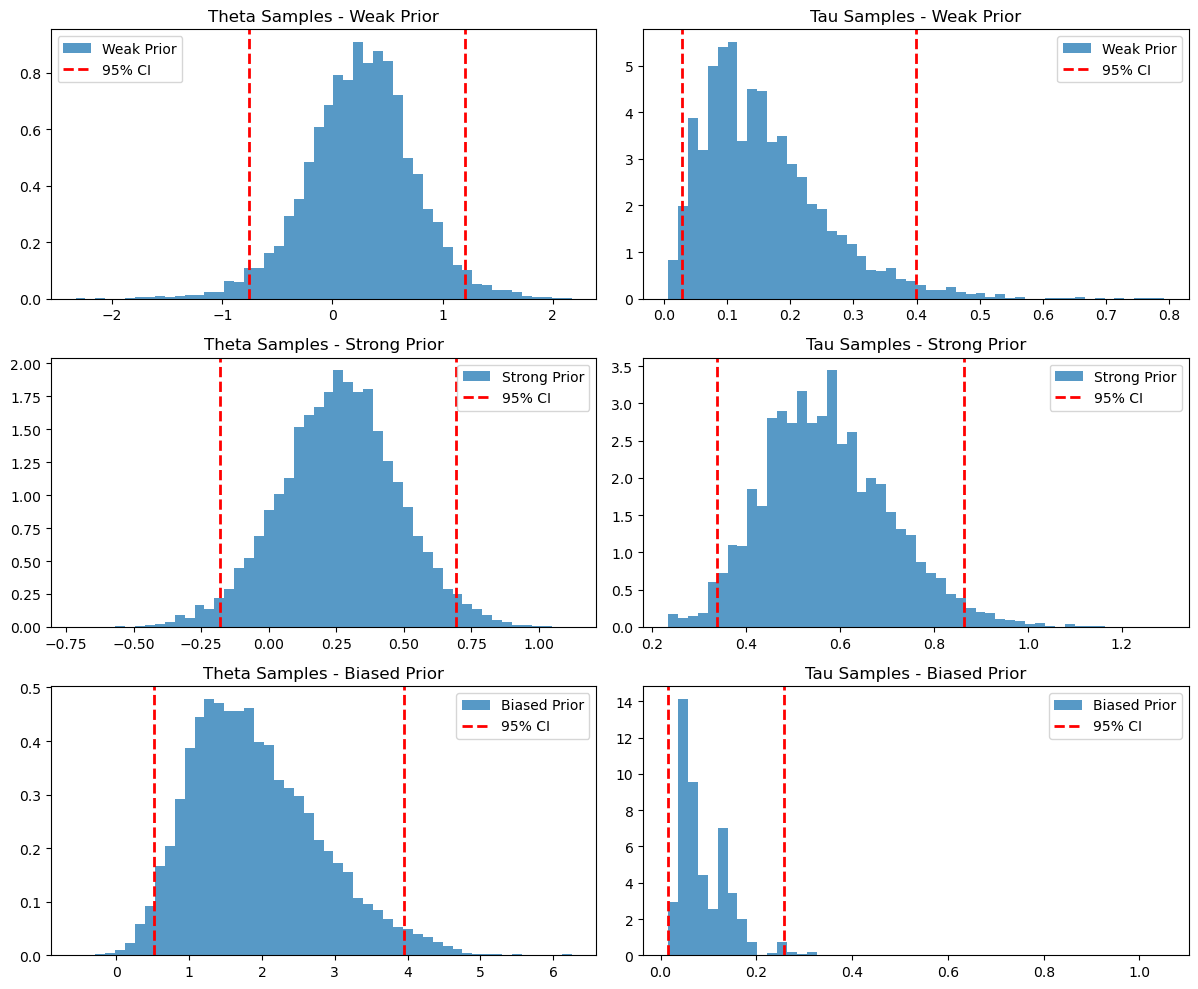

Weak Prior:
  Posterior mean of Theta: 0.254, 95% CI: [-0.75519432  1.20487887]
  Posterior mean of Tau: 0.159, 95% CI: [0.02844552 0.39965604]

Strong Prior:
  Posterior mean of Theta: 0.261, 95% CI: [-0.18107309  0.69250632]
  Posterior mean of Tau: 0.573, 95% CI: [0.33795796 0.86282851]

Biased Prior:
  Posterior mean of Theta: 1.914, 95% CI: [0.51605367 3.95599123]
  Posterior mean of Tau: 0.089, 95% CI: [0.01542884 0.25770663]



In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Given parameters
n = 30
m, s = 0, 1
x = stats.norm(loc=m, scale=s).rvs(size=n)
C, G = 2, 10000  # Chains and iterations

# Hyperparameters for different priors
prior_combinations = [
    {"alpha": 2, "lambda": 2, "theta_0": 0, "tau_0": 1, "label": "Weak Prior"},
    {"alpha": 10, "lambda": 10, "theta_0": 0, "tau_0": 5, "label": "Strong Prior"},
    {"alpha": 2, "lambda": 0.5, "theta_0": 5, "tau_0": 1, "label": "Biased Prior"}
]

samples_theta, samples_tau = [], []

for idx, priors in enumerate(prior_combinations):
    alpha, lambda_, theta_0, tau_0 = priors["alpha"], priors["lambda"], priors["theta_0"], priors["tau_0"]
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = np.mean(x)  # Initial guess for theta
    tau[:, 0] = 1  # Initial guess for tau
    
    for c in range(C):
        for g in range(1, G):
            # Propose new tau from prior (Gamma distribution)
            tau_proposal = stats.gamma.rvs(a=alpha, scale=1/lambda_)
            
            # Compute joint probability ratio (up to proportionality)
            likelihood_ratio = np.exp(-0.5 * tau_proposal * np.sum((x - theta[c, g-1])**2)) / \
                               np.exp(-0.5 * tau[c, g-1] * np.sum((x - theta[c, g-1])**2))
            prior_ratio = stats.gamma.pdf(tau_proposal, a=alpha, scale=1/lambda_) / \
                          stats.gamma.pdf(tau[c, g-1], a=alpha, scale=1/lambda_)
            
            accept_tau = np.random.rand() < min(1, likelihood_ratio * prior_ratio)
            tau[c, g] = tau_proposal if accept_tau else tau[c, g-1]
            
            # Propose new theta from normal distribution centered at previous value
            theta_proposal = stats.norm.rvs(loc=theta[c, g-1], scale=0.5)
            
            # Compute joint probability ratio (up to proportionality)
            likelihood_ratio = np.exp(-0.5 * tau[c, g] * np.sum((x - theta_proposal)**2)) / \
                               np.exp(-0.5 * tau[c, g] * np.sum((x - theta[c, g-1])**2))
            prior_ratio = stats.norm.pdf(theta_proposal, loc=theta_0, scale=np.sqrt(1/tau_0)) / \
                          stats.norm.pdf(theta[c, g-1], loc=theta_0, scale=np.sqrt(1/tau_0))
            
            accept_theta = np.random.rand() < min(1, likelihood_ratio * prior_ratio)
            theta[c, g] = theta_proposal if accept_theta else theta[c, g-1]
    
    samples_theta.append(theta[:, 20:].flatten())
    samples_tau.append(tau[:, 20:].flatten())

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for idx, priors in enumerate(prior_combinations):
    theta_ci = np.percentile(samples_theta[idx], [2.5, 97.5])
    tau_ci = np.percentile(samples_tau[idx], [2.5, 97.5])
    
    axes[idx, 0].hist(samples_theta[idx], bins=50, density=True, alpha=0.75, label=priors['label'])
    axes[idx, 0].axvline(theta_ci[0], color='red', linestyle='dashed', linewidth=2, label="95% CI")
    axes[idx, 0].axvline(theta_ci[1], color='red', linestyle='dashed', linewidth=2)
    axes[idx, 0].set_title(f"Theta Samples - {priors['label']}")
    axes[idx, 0].legend()
    
    axes[idx, 1].hist(samples_tau[idx], bins=50, density=True, alpha=0.75, label=priors['label'])
    axes[idx, 1].axvline(tau_ci[0], color='red', linestyle='dashed', linewidth=2, label="95% CI")
    axes[idx, 1].axvline(tau_ci[1], color='red', linestyle='dashed', linewidth=2)
    axes[idx, 1].set_title(f"Tau Samples - {priors['label']}")
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()

# Demonstrate Bayesian inference by summarizing posterior distributions
for idx, priors in enumerate(prior_combinations):
    theta_mean = np.mean(samples_theta[idx])
    tau_mean = np.mean(samples_tau[idx])
    theta_ci = np.percentile(samples_theta[idx], [2.5, 97.5])
    tau_ci = np.percentile(samples_tau[idx], [2.5, 97.5])
    print(f"{priors['label']}:")
    print(f"  Posterior mean of Theta: {theta_mean:.3f}, 95% CI: {theta_ci}")
    print(f"  Posterior mean of Tau: {tau_mean:.3f}, 95% CI: {tau_ci}\n")


For τ, we propose values independently from the prior distribution, ensuring positivity by using a Gamma distribution. The proposed value is then accepted or rejected based on the Metropolis acceptance ratio, which considers the likelihood and prior probabilities.

For θ, we propose values using a normal distribution centered at the previous value, with a moderate proposal variance. Again, we compute the acceptance probability based on the likelihood and prior ratio, accepting or rejecting the proposal accordingly.

The Bayesian inference results, as shown in the histograms and posterior summaries, demonstrate the impact of different priors. The weak prior leads to a broader credible interval, while the strong prior concentrates posterior estimates near zero. The biased prior shifts estimates toward its prior mean. These results contrast with the previous Gibbs sampler, where direct sampling from conditionals resulted in different mixing behavior and potentially faster convergence.

Overall, the Metropolis-within-Gibbs approach allows more flexibility when full conditionals are not analytically tractable, though it introduces potential efficiency concerns due to rejection steps in Metropolis updates.

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

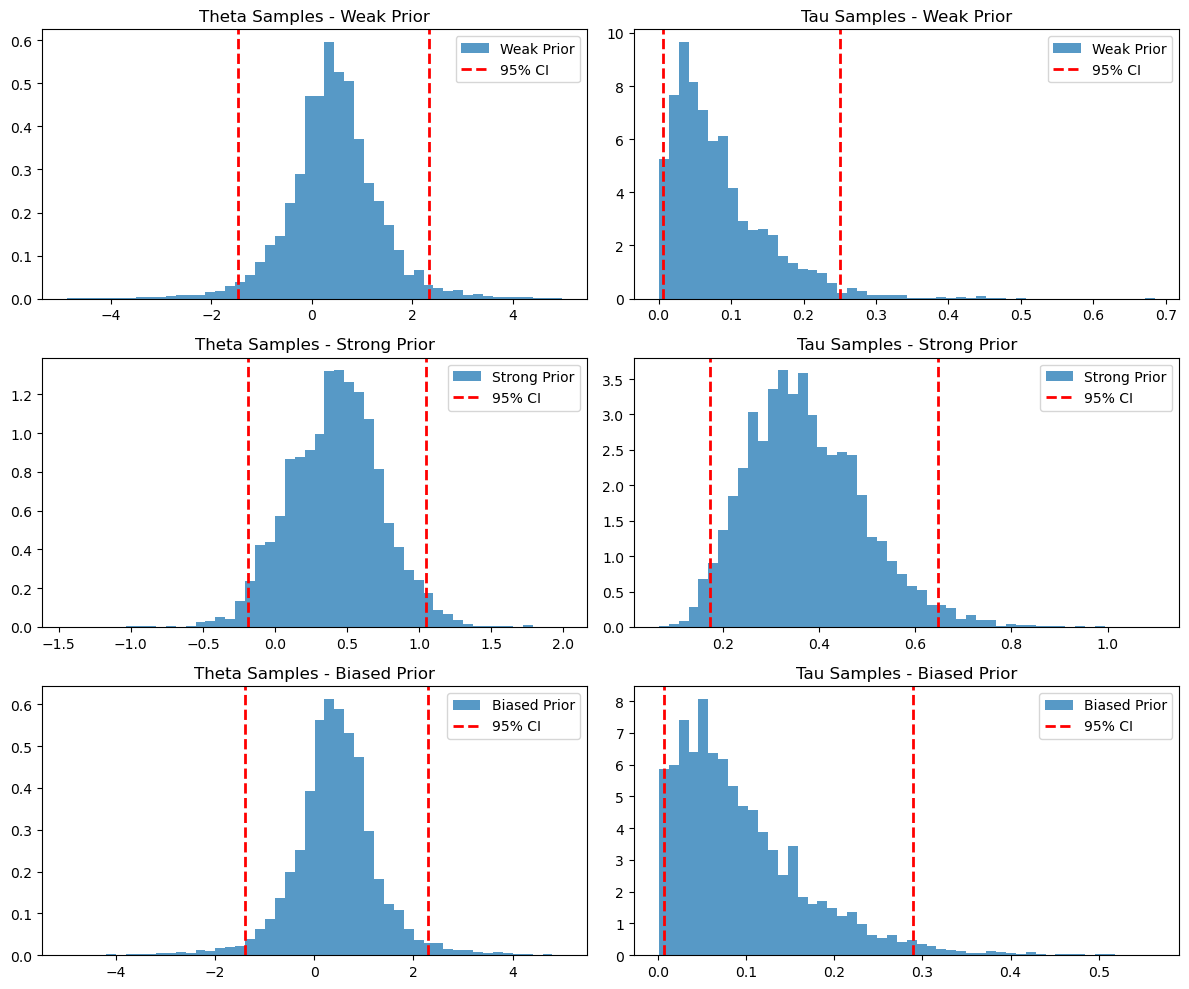

Weak Prior:
  Posterior mean of Theta: 0.429, 95% CI: [-1.46377565  2.33583154]
  Posterior mean of Tau: 0.084, 95% CI: [0.00597238 0.2498194 ]

Strong Prior:
  Posterior mean of Theta: 0.418, 95% CI: [-0.18605575  1.0498768 ]
  Posterior mean of Tau: 0.373, 95% CI: [0.1722549  0.64819193]

Biased Prior:
  Posterior mean of Theta: 0.420, 95% CI: [-1.38850711  2.29588203]
  Posterior mean of Tau: 0.096, 95% CI: [0.00702082 0.28932483]



In [4]:
# Given parameters
n = 30
m, s = 0, 1
x = stats.norm(loc=m, scale=s).rvs(size=n)
C, G = 2, 10000  # Chains and iterations

# Hyperparameters for different priors
prior_combinations = [
    {"alpha": 2, "lambda": 2, "theta_0": 0, "tau_0": 1, "label": "Weak Prior"},
    {"alpha": 10, "lambda": 10, "theta_0": 0, "tau_0": 5, "label": "Strong Prior"},
    {"alpha": 2, "lambda": 0.5, "theta_0": 5, "tau_0": 1, "label": "Biased Prior"}
]

samples_theta, samples_tau = [], []

for idx, priors in enumerate(prior_combinations):
    alpha, lambda_, theta_0, tau_0 = priors["alpha"], priors["lambda"], priors["theta_0"], priors["tau_0"]
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = np.mean(x)  # Initial guess for theta
    tau[:, 0] = 1  # Initial guess for tau
    
    for c in range(C):
        for g in range(1, G):
            # Propose new tau using a truncated normal distribution
            tau_t_minus_1 = tau[c, g-1]
            tau_proposal = stats.truncnorm.rvs(a=-tau_t_minus_1/s, b=np.inf, loc=tau_t_minus_1, scale=s)
            
            # Compute joint probability ratio (up to proportionality)
            likelihood_ratio = np.exp(-0.5 * tau_proposal * np.sum((x - theta[c, g-1])**2)) / \
                               np.exp(-0.5 * tau[c, g-1] * np.sum((x - theta[c, g-1])**2))
            prior_ratio = stats.gamma.pdf(tau_proposal, a=alpha, scale=1/lambda_) / \
                          stats.gamma.pdf(tau[c, g-1], a=alpha, scale=1/lambda_)
            
            accept_tau = np.random.rand() < min(1, likelihood_ratio * prior_ratio)
            tau[c, g] = tau_proposal if accept_tau else tau[c, g-1]
            
            # Propose new theta from a uniform distribution instead of normal
            theta_proposal = stats.uniform.rvs(loc=-5, scale=10)  # Uniform proposal from [-5,5]
            
            # Compute joint probability ratio (up to proportionality)
            likelihood_ratio = np.exp(-0.5 * tau[c, g] * np.sum((x - theta_proposal)**2)) / \
                               np.exp(-0.5 * tau[c, g] * np.sum((x - theta[c, g-1])**2))
            prior_ratio = stats.uniform.pdf(theta_proposal, loc=-5, scale=10) / \
                          stats.uniform.pdf(theta[c, g-1], loc=-5, scale=10)
            
            accept_theta = np.random.rand() < min(1, likelihood_ratio * prior_ratio)
            theta[c, g] = theta_proposal if accept_theta else theta[c, g-1]
    
    samples_theta.append(theta[:, 20:].flatten())
    samples_tau.append(tau[:, 20:].flatten())

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for idx, priors in enumerate(prior_combinations):
    theta_ci = np.percentile(samples_theta[idx], [2.5, 97.5])
    tau_ci = np.percentile(samples_tau[idx], [2.5, 97.5])
    
    axes[idx, 0].hist(samples_theta[idx], bins=50, density=True, alpha=0.75, label=priors['label'])
    axes[idx, 0].axvline(theta_ci[0], color='red', linestyle='dashed', linewidth=2, label="95% CI")
    axes[idx, 0].axvline(theta_ci[1], color='red', linestyle='dashed', linewidth=2)
    axes[idx, 0].set_title(f"Theta Samples - {priors['label']}")
    axes[idx, 0].legend()
    
    axes[idx, 1].hist(samples_tau[idx], bins=50, density=True, alpha=0.75, label=priors['label'])
    axes[idx, 1].axvline(tau_ci[0], color='red', linestyle='dashed', linewidth=2, label="95% CI")
    axes[idx, 1].axvline(tau_ci[1], color='red', linestyle='dashed', linewidth=2)
    axes[idx, 1].set_title(f"Tau Samples - {priors['label']}")
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()

# Demonstrate Bayesian inference by summarizing posterior distributions
for idx, priors in enumerate(prior_combinations):
    theta_mean = np.mean(samples_theta[idx])
    tau_mean = np.mean(samples_tau[idx])
    theta_ci = np.percentile(samples_theta[idx], [2.5, 97.5])
    tau_ci = np.percentile(samples_tau[idx], [2.5, 97.5])
    print(f"{priors['label']}:")
    print(f"  Posterior mean of Theta: {theta_mean:.3f}, 95% CI: {theta_ci}")
    print(f"  Posterior mean of Tau: {tau_mean:.3f}, 95% CI: {tau_ci}\n")


The necessity of analytically determining the full conditional distributions in Gibbs sampling depends on the complexity of the problem and the feasibility of obtaining closed-form conditionals. In standard Gibbs sampling, having full conditional distributions allows for direct sampling from well-defined probability distributions, leading to efficient convergence and accurate posterior estimation. However, in cases where full conditionals are intractable or difficult to derive, a Metropolis-within-Gibbs approach can be employed.

By using Metropolis-Hastings updates within Gibbs sampling, we can sample from the joint posterior distribution without requiring explicit derivations of full conditionals. Instead, we only need to evaluate the joint distribution (up to a proportional constant) and construct appropriate proposal distributions. This flexibility makes Metropolis-within-Gibbs a powerful alternative when conjugacy does not hold or when the posterior distributions are complex.

The adjusted Metropolis-within-Gibbs sampler in this implementation demonstrates how dependent proposals for τ (using a truncated normal) and non-Gaussian priors for θ (using a uniform prior) still enable effective Bayesian inference. The posterior distributions remain well-defined, and credible intervals provide meaningful uncertainty quantification, even without explicitly deriving full conditional distributions. This highlights the practicality of hybrid MCMC methods in Bayesian computation.

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$




The **Metropolis-Hastings (MH)** algorithm is designed to sample from a target stationary distribution $p(x)$. The transition probabilities are governed by the proposal distribution $q(\tilde{x} | x)$ and an acceptance probability that ensures detailed balance.

### Proposal Distribution $q(x' | x)$
The given proposal distribution is symmetric:

$q(\tilde{x}^{(t)} | x^{(t-1)})$ =
\begin{cases} 
1/2, & \text{if transitioning from 0 to 1 or vice versa} \\
1/2, & \text{if staying at the current state}
\end{cases}

Since this is symmetric, the ratio 

$
\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})}
$

cancels out in the Metropolis-Hastings acceptance probability.

### Target Stationary Distribution $ p(x) $
The desired stationary distribution is:

$
p(x=0) = \frac{1}{3}, \quad p(x=1) = \frac{2}{3}
$

This means that on average, the Markov Chain should spend $ 1/3 $ of the time in state 0 and $ 2/3 $ of the time in state 1.

### Transition Kernel $ K $
The MH algorithm constructs a Markov Chain with the transition probabilities:

- If the current state is $ x = 0 $, the chain will propose $ x' = 1 $ with probability $1/2$. The acceptance probability is:
$
\alpha = \min\left(1, \frac{p(1)}{p(0)}\right) = \min\left(1, \frac{2/3}{1/3}\right) = 1
$

So, the probability of transitioning to 1 is:
$
(1/2) \times 1 = 1/2
$

and the probability of staying at 0 is:

$
1 - 1/2 = 1/2
$

- If the current state is $ x = 1 $, the chain will propose $x' = 0$ with probability $ 1/2 $. The acceptance probability is:

$
\alpha = \min\left(1, \frac{p(0)}{p(1)}\right) = \min\left(1, \frac{1/3}{2/3}\right) = 1/2
$

So, the probability of transitioning to 0 is:

$
(1/2) \times (1/2) = 1/4
$

and the probability of staying at 1 is:

$
1 - 1/4 = 3/4
$

This gives us the transition matrix:

$K  = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


This means that:
- If currently at 0, there's a 50% chance of staying at 0 and a 50% chance of transitioning to 1.
- If currently at 1, there's a 75% chance of staying at 1 and a 25% chance of transitioning to 0.

This leads to **geometric distributions** of run lengths with expected durations of 2 for state 0 and 4 for state 1, which results in the desired **\( 1/3 \) to \( 2/3 \) stationary distribution**.


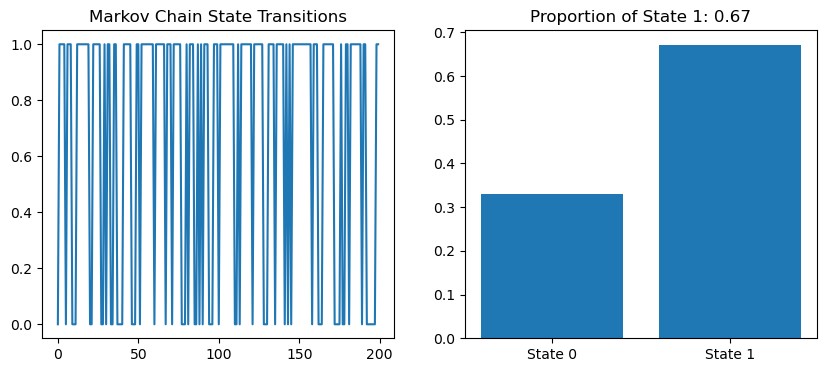

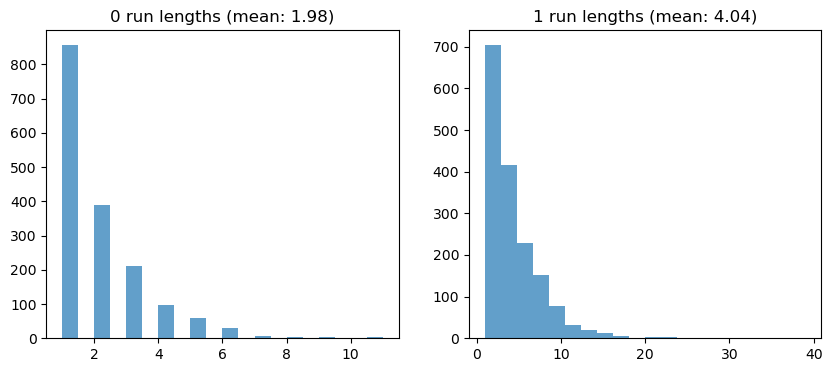

Empirical stationary distribution: [0.333 0.667]
Theoretical stationary distribution: [0.333 0.667]


In [6]:
# Transition matrix
K = np.array([[0.5, 0.25], 
              [0.5, 0.75]])

# Simulate Markov Chain
T = 10000
s_t = np.zeros(T, dtype=int)  # Start at state 0

for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])  # Sample next state

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(s_t[:200])  # Show first 200 transitions
ax[0].set_title("Markov Chain State Transitions")

ax[1].hist(s_t, bins=[-0.5, 0.5, 1.5], density=True, rwidth=0.8)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["State 0", "State 1"])
ax[1].set_title(f"Proportion of State 1: {s_t.mean():.2f}")

plt.show()

# Compute run lengths for state 0 and state 1
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1, T):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1

# Plot run length distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length, bins=20, alpha=0.7)
ax[0].set_title(f"0 run lengths (mean: {np.mean(state0_run_length):.2f})")

ax[1].hist(state1_run_length, bins=20, alpha=0.7)
ax[1].set_title(f"1 run lengths (mean: {np.mean(state1_run_length):.2f})")

plt.show()

# Print results
print(f"Empirical stationary distribution: {empirical_distribution.round(3)}")
print(f"Theoretical stationary distribution: {theoretical_distribution.round(3)}")